<a href="https://colab.research.google.com/github/AndreKaled/classificador-cao-gato/blob/main/classificador_cao_gato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Descrição inicial
blabla isso classifica caes e gatinhos
# sumario pra acompanhar?
seria bom eu acho


## Instalando dependências

In [1]:
%pip install LTNtorch kagglehub pandas torchvision matplotlib

Note: you may need to restart the kernel to use updated packages.


## Importando bibliotecas

In [2]:
import pandas as pd
import os
import warnings
import kagglehub
from kagglehub import KaggleDatasetAdapter
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split
import ltn
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

/home/plaaeo/uni/ia/classificador-cao-gato/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Baixando dataset com imagens de cães e gatos

In [3]:
# Baixa e extrai
dataset_name = "shaunthesheep/microsoft-catsvsdogs-dataset"
dataset_path = kagglehub.dataset_download(dataset_name)

print("Dataset baixado em:", dataset_path)

Dataset baixado em: /home/plaaeo/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1


### Explorando estrutura do dataset

In [4]:
print(os.listdir(dataset_path))

['readme[1].txt', 'PetImages', 'MSR-LA - 3467.docx']


In [5]:
main_folder_path = Path(dataset_path)

all_folders = [d for d in main_folder_path.glob('**/') if d.is_dir()]

# Count number of files in each class
data = []
for folder in all_folders:
    folder_name = folder.name
    file_count = len(list(folder.glob('*.*')))
    if folder_name != dataset_path:
        data.append({'Folder Name': folder_name, 'File Count': file_count})

count = pd.DataFrame(data)

count = count.set_index('Folder Name')
count

,File Count
Folder Name,
1,2
PetImages,0
Cat,12501
Dog,12501


In [6]:
print(f'Total {count.sum()}')

Total File Count    25004
dtype: int64


In [7]:
# mostra 5 imagens da classe
def plot_imgs(item_dir, top=10):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:5]

    plt.figure(figsize=(10, 10))

    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)

        img = plt.imread(img_path)
        plt.tight_layout()
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(os.path.basename(item_dir))

In [8]:
# entra na pasta certa, contendo as pastas com as imagens
print(os.listdir(os.path.join(dataset_path, 'PetImages')))
dataset_path = os.path.join(dataset_path, 'PetImages')

['Cat', 'Dog']


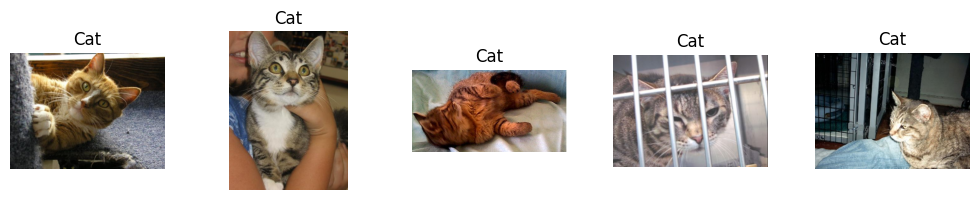

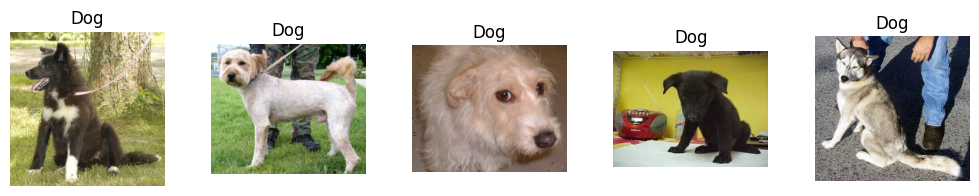

In [9]:
plot_imgs(dataset_path + '/Cat')
plot_imgs(dataset_path + '/Dog')

## Preparando DataLoader pra Pytorch

In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), # padroniza o tamanho de cada imagem
    transforms.ToTensor()
])

# dataset
print('oii')
dataset = datasets.ImageFolder(dataset_path, transform=transform)

# dividindo em treino e validação
train_size = int(0.85 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Separar dataset de treino em gatos e cães
idx_to_class =  {v: k for k, v in dataset.class_to_idx.items()}
train_indices = { v: [ ] for v in idx_to_class.values() }
for i in train_dataset.indices:
    path, label = dataset.imgs[i]
    label_txt = idx_to_class[label]
    train_indices[label_txt].append(i)

train_cats = Subset(dataset, train_indices['Cat'])
train_dogs = Subset(dataset, train_indices['Dog'])

# dataloaders
train_cats_loader = DataLoader(train_cats, batch_size=32, shuffle=True)
train_dogs_loader = DataLoader(train_dogs, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Total de imagens:", len(dataset))
print("Treino:", len(train_cats), "gatos,", len(train_dogs), "cães | Validação:", len(val_dataset))


oii
Total de imagens: 25000
Treino: 10575 gatos, 10675 cães | Validação: 3750


## Preparando CNN


In [ ]:
class CNNClassificador(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()

        # camadas convolucionais: detectam padrões na imagem (bordas, texturas, formas)
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # reduz resolução pela metade

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        # flatten + fully connected: transforma padrões em saidas classificaveis
        self.fc1 = nn.Linear(128*28*28, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.fc4 = nn.Sigmoid()

    def forward(self, x):
        # convolução + ReLU + Pooling
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        # achata para passar pelas fully connected
        #print(x.size())
        x = x.view(x.size(0), -1)
        #print(x.size())
        x = F.relu(self.fc1(x))
        #print(x.size())
        x = self.dropout(x)
        #print(x.size())
        x = F.relu(self.fc2(x))
        #print(x.size())

        # saida final: pontuação para cada classe
        #print(x.size())
        x = self.fc3(x)
        x = self.fc4(x)
        return x

model = CNNClassificador(num_classes=2)
print(model)

CNNClassificador(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (fc4): Sigmoid()
)


## Preparando treino da CNN

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
ltn.device = device
model.to(device)

# função de perda padrão de classificacao binaria
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


### Lógica LTN

In [13]:
# With square kernels and equal stride
#n = nn.Conv2d(3, 32, 1)
#m = nn.MaxPool2d(2, 2)
#m = nn.MaxPool2d((3, 2), stride=(2, 1))
#input = torch.randn(3, 224, 224)
#print("Balbalba")
#output = model(input)
#print(input.size())
#print(o1.size())
#print(output.size())
#print(output)

In [14]:
# Define os Agregadores e Otimizador
# Define logical operators
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
And = ltn.Connective(ltn.fuzzy_ops.AndProd())
Or = ltn.Connective(ltn.fuzzy_ops.OrProbSum())
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=2), quantifier="e")
# SatAgg (Agregador de Satisfação) calculará a satisfação total da KB
sat_agg = ltn.fuzzy_ops.SatAgg()

In [ ]:
# escrever a logica ltn aqui :)
C = ltn.Predicate(func=lambda x: model(x)[:,0])
D = ltn.Predicate(func=lambda x: model(x)[:,1])

#print(P)

train_loader = zip(train_cats_loader, train_dogs_loader)

# Loop de Treinamento
#for epoch in range(20):
for epoch, (cats, dogs) in enumerate(train_loader):
    cat = cats[0]
    dog = dogs[0]
    #for cat, dog in zip(cats[0], dogs[0]):
    optimizer.zero_grad()

    # 1. Defina as variáveis LTN com os dados de treinamento
    x_C = ltn.Variable("x_C", cat)
    x_D = ltn.Variable("x_D", dog)

    # 2. Formule os axiomas
    # Axioma 1: Para todo x_C, A(x_C) deve ser verdadeiro
    axiom_C = Forall(x_C, C(x_C))
    axiom_NC = Forall(x_D, Not(C(x_D)))
    
    # Axioma 2: Para todo x_D, Não(A(x_D)) deve ser verdadeiro
    axiom_D = Forall(x_D, D(x_D))
    axiom_ND = Forall(x_C, Not(D(x_C)))

    # 3. Calcule a satisfação total da Base de Conhecimento
    sat = sat_agg(axiom_C, axiom_D, axiom_NC, axiom_ND)
    
    # 4. Calcule a perda (loss)
    loss = 1. - sat

    # 5. Backpropagation e Otimização
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch}: Nível de Satisfação (Sat): {sat.item():.4f}, Perda (Loss): {loss.item():.4f}")

print("Treinamento concluído.")

Predicate(model=CNNClassificador(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (fc4): Sigmoid()
))


AcceleratorError: CUDA error: no kernel image is available for execution on the device
Search for `cudaErrorNoKernelImageForDevice' in https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__TYPES.html for more information.
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
